# Package

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
print(tf.__version__)
print(keras.__version__)

2.3.1
2.4.0


# Variables

In [5]:
height = 32
width = 32
channels = 3
latent_dim = 256
batch_size = 10
epochs = 20

# Function and Model

In [3]:
def PreprocessData(X_Train, X_Test):
    #Normalize picture
    X_Train = X_Train.astype('float32')
    X_Test = X_Test.astype('float32')
    X_Train = ((X_Train - np.min(X_Train)) / (np.max(X_Train) - np.min(X_Train)) - 0.5) * 2
    X_Test = ((X_Test - np.min(X_Test)) / (np.max(X_Test) - np.min(X_Test)) - 0.5) * 2
    #split training data into training and validation set
    X_Train_gray = rgb_2_gray(X_Train).reshape(-1,32, 32, 1)
    X_Test_gray = rgb_2_gray(X_Test).reshape(-1,32, 32, 1)
    X_train_gray, X_valid_gray, X_train, X_valid = train_test_split(X_Train_gray, X_Train, test_size=0.2, random_state=7, shuffle= True)
    return ((X_train_gray, X_train), (X_valid_gray, X_valid), (X_Test_gray, X_Test))

In [4]:
def Aug_Data(X_train, Y_train, X_valid, Y_valid, batch_size):
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    )
    validation_datagen = keras.preprocessing.image.ImageDataGenerator()
    train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
    valid_generator = validation_datagen.flow(X_valid, Y_valid, batch_size=batch_size)
    return train_generator, valid_generator

In [5]:
def rgb_2_gray(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

In [6]:
def encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = inputs
    x = Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    x = Conv2D(filters=256, kernel_size=3, strides=2, activation='relu', padding='same')(x)
    shape = K.int_shape(x)
    x = Flatten()(x)
    latent = Dense(latent_dim)(x)
    return shape, inputs, Model(inputs, latent)

In [7]:
def decoder(latent_dim, shape):
    latent_inputs = Input(shape=(latent_dim))
    x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)
    x = Conv2DTranspose(filters=256, kernel_size=3, strides = 2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(filters=128, kernel_size=3, strides = 2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(filters=64, kernel_size=3, strides = 2, activation='relu', padding='same')(x)
    output = Conv2DTranspose(filters=3, kernel_size=3, activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, output)


# Data Preprocess

In [8]:
cifar100 = keras.datasets.cifar100.load_data()
(x_train_all, y_train_all), (x_test, y_test) = cifar100
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = PreprocessData(x_train_all, x_test)
train_generator, valid_generator = Aug_Data(X_train, Y_train, X_valid, Y_valid, batch_size)
print(X_train.shape)
print(Y_train.shape)

169009152/169001437 [==============================] - 11s 0us/step
(40000, 32, 32, 1)
(40000, 32, 32, 3)


# Training Process

In [9]:
earlystop = keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True, verbose=1)
cp = keras.callbacks.ModelCheckpoint(filepath = 'best_model.h5',save_best_only = True,verbose=1)
lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_delta=0.0001)
callbacks = [earlystop, cp, lr]

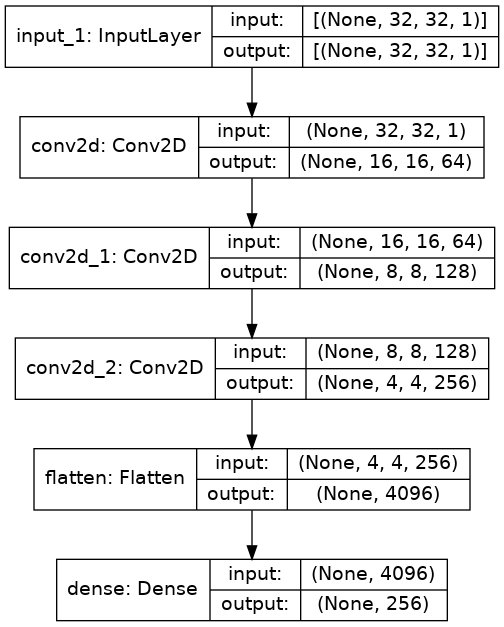

In [10]:
shape, inputs, Encoder = encoder((height, width, 1))
Decoder = decoder(latent_dim, shape)
autoencoder = Model(inputs, Decoder(Encoder(inputs)))
autoencoder.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
plot_model(Encoder, to_file='encoder.png', show_shapes=True)

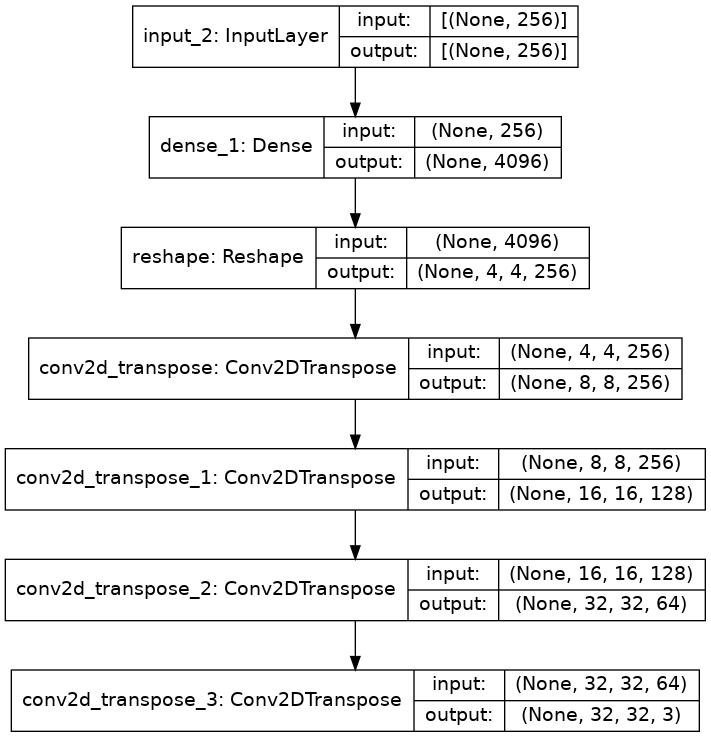

In [11]:
plot_model(Decoder, to_file='decoder.png', show_shapes=True)

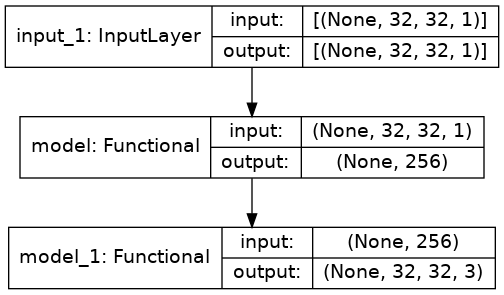

In [12]:
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

In [13]:
history = autoencoder.fit(train_generator, epochs=epochs, 
                steps_per_epoch=X_train.shape[0]//batch_size, 
                validation_data=valid_generator, validation_steps=len(valid_generator) // batch_size,
                callbacks=callbacks, verbose=1)

Epoch 1/20
4000/4000 [==============================] - 30s 7ms/step - loss: 0.2939 - accuracy: 0.5502 - val_loss: 0.2917 - val_accuracy: 0.5581

Epoch 00001: val_loss improved from inf to 0.29165, saving model to best_model.h5
Epoch 2/20
4000/4000 [==============================] - 26s 7ms/step - loss: 0.2892 - accuracy: 0.5498 - val_loss: 0.2962 - val_accuracy: 0.5639

Epoch 00002: val_loss did not improve from 0.29165
Epoch 3/20
4000/4000 [==============================] - 26s 7ms/step - loss: 0.2893 - accuracy: 0.5526 - val_loss: 0.2868 - val_accuracy: 0.5583

Epoch 00003: val_loss improved from 0.29165 to 0.28683, saving model to best_model.h5
Epoch 4/20
4000/4000 [==============================] - 26s 7ms/step - loss: 0.2901 - accuracy: 0.5525 - val_loss: 0.2863 - val_accuracy: 0.5669

Epoch 00004: val_loss improved from 0.28683 to 0.28633, saving model to best_model.h5
Epoch 5/20
4000/4000 [==============================] - 26s 7ms/step - loss: 0.2884 - accuracy: 0.5511 - val_lo

# Test

In [14]:
autoencoder.evaluate(X_test, Y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2914 - accuracy: 0.5566


[0.29144537448883057, 0.5565659403800964]

# Cifar10

In [15]:
cifar10 = keras.datasets.cifar10.load_data()
(x_train_all, y_train_all), (x_test, y_test) = cifar10
(X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test) = PreprocessData(x_train_all, x_test)
train_generator, valid_generator = Aug_Data(X_train, Y_train, X_valid, Y_valid, batch_size)
print(X_train.shape)
print(Y_train.shape)

170500096/170498071 [==============================] - 6s 0us/step
(40000, 32, 32, 1)
(40000, 32, 32, 3)


In [16]:
shape, inputs, Encoder = encoder((height, width, 1))
Decoder = decoder(latent_dim, shape)
autoencoder = Model(inputs, Decoder(Encoder(inputs)))
autoencoder.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

In [17]:
history = autoencoder.fit(train_generator, epochs=epochs, 
                steps_per_epoch=X_train.shape[0]//batch_size, 
                validation_data=valid_generator, validation_steps=len(valid_generator) // batch_size,
                callbacks=callbacks, verbose=1)

Epoch 1/20
4000/4000 [==============================] - 27s 7ms/step - loss: 0.2621 - accuracy: 0.5044 - val_loss: 0.2525 - val_accuracy: 0.4941

Epoch 00001: val_loss improved from 0.28092 to 0.25251, saving model to best_model.h5
Epoch 2/20
4000/4000 [==============================] - 28s 7ms/step - loss: 0.2557 - accuracy: 0.5087 - val_loss: 0.2574 - val_accuracy: 0.5143

Epoch 00002: val_loss did not improve from 0.25251
Epoch 3/20
4000/4000 [==============================] - 28s 7ms/step - loss: 0.2555 - accuracy: 0.5113 - val_loss: 0.2544 - val_accuracy: 0.5107

Epoch 00003: val_loss did not improve from 0.25251
Epoch 4/20
4000/4000 [==============================] - 28s 7ms/step - loss: 0.2558 - accuracy: 0.5104 - val_loss: 0.2628 - val_accuracy: 0.5270

Epoch 00004: val_loss did not improve from 0.25251
Epoch 5/20
4000/4000 [==============================] - 27s 7ms/step - loss: 0.2553 - accuracy: 0.5107 - val_loss: 0.2606 - val_accuracy: 0.5267

Epoch 00005: val_loss did not i

# Test

In [18]:
autoencoder.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.2546 - accuracy: 0.5086


[0.2546379268169403, 0.5085741281509399]

In [6]:
%who int

batch_size	 channels	 epochs	 height	 latent_dim	 width	 
